In [121]:
import pandas as pd
import numpy as np
from glob import glob
from path import Path
import json
import seaborn as sns
import prody
from multiprocessing import Pool
from tqdm import tqdm
import itertools
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import OrderedDict, Counter, defaultdict
import traceback
import urllib
import pybel
from copy import deepcopy
from multiprocessing import Pool
from pymol import cmd

pd.set_option('display.max_columns', None)

from alphadock import utils
from alphadock import features

In [122]:
case_keys = utils.read_json('data/cases_filt_keys.json')
len(case_keys)

23671

In [127]:
for x in case_keys:
    if x[0] == '1E59_A':
        print(x)

['1E59_A', 'VO3']


In [3]:
case_dicts = {y: utils.read_json(Path('data/cases/') / y / 'case.json') for y in tqdm(sorted(set([x[0] for x in case_keys])))}

100%|██████████| 20440/20440 [01:54<00:00, 179.18it/s]


In [23]:
target_list = []
for case_name, group_name in case_keys:
    case_dict = case_dicts[case_name]
    if len(case_dict['entity_info']['pdbx_seq_one_letter_code_can']) > 400:
        continue
    group_dict = {x['name']: x for x in case_dict['ligand_groups']}[group_name]
    if sum([x['num_heavy_atoms'] for x in group_dict['ligands']]) > 50:
        continue
    if all([x['num_heavy_atoms'] == 1 for x in group_dict['ligands']]):
        continue
    target_list.append((case_name, group_name))
len(target_list)

11796

In [25]:
def parse_hhr_file(hhr_file, num_top=None):
    with open(hhr_file, 'r') as f:
        lines = f.readlines()
        
    assert int(lines[9].split()[0]) == 1
    q_chain = Path(hhr_file).basename().stripext()
    
    break_line = None
    for i, line in enumerate(lines[9:], 9):
        if line.strip() == '':
            break_line = i
            break
        int(line.split()[0])
        
    out = OrderedDict()
    for line in lines[9:break_line][:num_top]:
        pdb_chain = line.split()[1]
        if pdb_chain in out:
            continue
        #split = line.split()
        q_range = line[75:84].split('-')
        t_range = line[85:94].split('-')
        out[pdb_chain] = OrderedDict(
            hh_pdb=pdb_chain.upper(),
            hh_prob=float(line[35:40]),
            hh_identity=None,
            hh_evalue=None,
            query_aln='',
            target_aln='',
            query_range=[int(q_range[0])-1, int(q_range[1])],
            target_range=[int(t_range[0])-1, int(t_range[1])]
        )
        
    counter = 0
    t_chain = None
    skip = False
    
    for idx in range(break_line + 1, len(lines)):
        line = lines[idx]
        if line.startswith('>'):
            # sanity check for previous target's alignment
            if t_chain is not None:
                last_chain = out[t_chain]
                #assert len(last_chain['query_aln']) == len(last_chain['target_aln'])
                
            t_chain = line.split()[0][1:]
            
            # hhr can have multiple alignments for the same chain
            # we keep only the first one
            skip = out[t_chain]['hh_identity'] is not None
            if skip: 
                continue
            
            # extract alignment scores
            scores = lines[idx+1].split()
            identity = scores[4]
            assert identity.startswith('Iden')
            identity = float(identity.split('=')[1].strip('%'))
            
            evalue = scores[1]
            assert evalue.startswith('E-value')
            evalue = float(evalue.split('=')[1].strip('%'))
            
            out[t_chain]['hh_identity'] = identity
            out[t_chain]['hh_evalue'] = evalue
            counter += 1
            
        if skip:
            continue
            
        # record Q alignment
        if line.startswith(f'Q {q_chain}'):
            s = line.split()
            out[t_chain]['query_aln'] += s[3]
            
            #begin, end = int(s[2]), int(s[4])
            #cur_range = out[t_chain]['query_range'] 
            # sanity check that alignment chunks in hhr file are contiguous
            #if len(cur_range) > 0: 
            #    assert begin-1 == cur_range[-1]
            #out[t_chain]['query_range'] += [begin-1, end]
            
        # record target alignment
        if t_chain is not None and line.startswith(f'T {t_chain}'):
            s = line.split()
            out[t_chain]['target_aln'] += s[3]
            
            #begin, end = int(s[2]), int(s[4])
            #cur_range = out[t_chain]['target_range'] 
            # sanity check that alignment chunks in hhr file are contiguous
            #if len(cur_range) > 0: 
            #    assert begin-1 == cur_range[-1]
            #out[t_chain]['target_range'] += [begin-1, end]
            
        if num_top is not None and counter >= num_top:
            break
           
    #for item in out.values():
    #    item['query_range'] = [min(item['query_range']), max(item['query_range'])]
    #    item['target_range'] = [min(item['target_range']), max(item['target_range'])]
    #    #print(item)
    #    #assert (item['target_range'][1] - item['target_range'][0]) == (item['query_range'][1] - item['query_range'][0])
            
    return out

In [36]:
cc_names = sorted(set([x for x, _ in target_list]))
cc_names_to_node_id = {y: x for x, y in enumerate(cc_names)}
#cc_array = np.arange(len(cc_names), dtype=int)
#cc_array

In [42]:
import networkx as nx
G = nx.Graph()

for case_name in tqdm(cc_names):
    hhr = parse_hhr_file(Path('data/hhpred/') / case_name[:5].lower() + case_name[5:] + '.hhr')
    src_node = cc_names_to_node_id[case_name]
    for tpl_chain, tpl_data in hhr.items():
        dst_node = cc_names_to_node_id.get(tpl_chain.upper())
        if dst_node is not None:
            G.add_edge(src_node, dst_node)

100%|█████████▉| 10988/10989 [37:46<00:00,  4.85it/s] 


FileNotFoundError: [Errno 2] No such file or directory: Path('data/hhpred/9jdw_A.hhr')

In [78]:
ccs = sorted([list(x) for x in nx.connected_components(G)], key=lambda x: -len(x))

In [79]:
len(ccs)

243

In [80]:
sum([len(x) for x in ccs[-100:]])

100

Num valid chains: 291
Num valid seqclus30: 223
Num valid cases: 305


<AxesSubplot:ylabel='Count'>

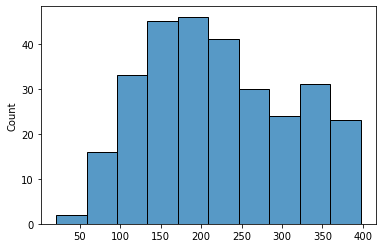

In [99]:
import functools
valid_nodes = list(functools.reduce(lambda x,y: x+y, ccs[-180:]))
valid_chains = [cc_names[x] for x in valid_nodes]
print('Num valid chains:', len(valid_nodes))
print('Num valid seqclus30:', len(Counter([case_dicts[cc_names[x]]['seqclus30'] for x in valid_nodes])))
print('Num valid cases:', len([x for x in target_list if x[0] in valid_chains]))
sns.histplot([len(case_dicts[cc_names[x]]['entity_info']['pdbx_seq_one_letter_code_can']) for x in valid_nodes])

Num train chains: 10698
Num train seqclus30: 1497
Num train cases: 11491


<AxesSubplot:ylabel='Count'>

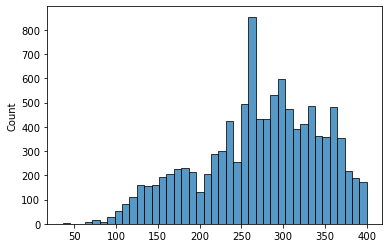

In [100]:
train_nodes = list(functools.reduce(lambda x,y: x+y, ccs[:-180]))
 = [cc_names[x] for x in train_nodes]
print('Num train chains:', len(train_nodes))
print('Num train seqclus30:', len(Counter([case_dicts[cc_names[x]]['seqclus30'] for x in train_nodes])))
print('Num train cases:', len([x for x in target_list if x[0] in train_chains]))
sns.histplot([len(case_dicts[cc_names[x]]['entity_info']['pdbx_seq_one_letter_code_can']) for x in train_nodes])

In [124]:
train_set = []
seqclus_sizes = Counter([case_dicts[cc_names[x]]['seqclus30'] for x in train_nodes])
for x in target_list:
    if x[0] in train_chains:
        train_set.append({
            'case_name': x[0],
            'group_name': x[1],
            'seqclus_size': seqclus_sizes[case_dicts[x[0]]['seqclus30']]
        })
print('Train set size:', len(train_set))
utils.write_json({'cases': train_set, 'template_pool': case_keys}, 'data/train_split/train_12k.json')

Train set size: 11491


In [125]:
valid_set = []
for x in target_list:
    if x[0] in valid_chains:
        valid_set.append({
            'case_name': x[0],
            'group_name': x[1]
        })
print('Valid set size:', len(valid_set))
utils.write_json({'cases': valid_set, 'template_pool': case_keys}, 'data/train_split/valid_12k.json')

Valid set size: 305


In [126]:
utils.write_json({'cases': train_set[:1000:100], 'template_pool': case_keys}, 'data/train_split/debug.json')

In [118]:
case_dicts['1CLL_A']

{'case_name': '1CLL_A',
 'pdb_id': '1CLL',
 'pdb_chain': 'A',
 'instance_id': 'A',
 'entity_id': '1',
 'experiment': 'X-RAY DIFFRACTION',
 'resolution': 1.7,
 'deposition_date': '1992-09-29T00:00:00+0000',
 'seqclus100': 94,
 'seqclus90': 75,
 'seqclus40': 54,
 'seqclus30': 56,
 'missing_residue': '1110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001',
 'missing_ca': '1110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001',
 'missing_atoms': '1111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001',
 'entity_info': {'nstd_linkage': 'no',
  'nstd_monomer': 'no',
  'pdbx_seq_one_letter_code': 'ADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTD